In [ ]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/m9_딥러닝알고리즘구현/dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
# 넘파이 배열로 변환
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] # 날짜를 제외한 나머지
    float_data[i, :] = values

In [ ]:
float_data.shape

(420551, 14)

In [ ]:
float_data[:,1]

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

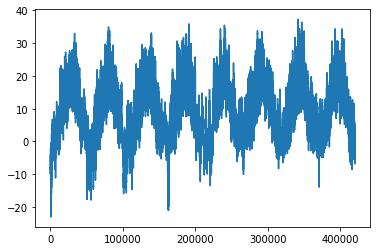

In [ ]:
from matplotlib import pyplot as plt  

temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

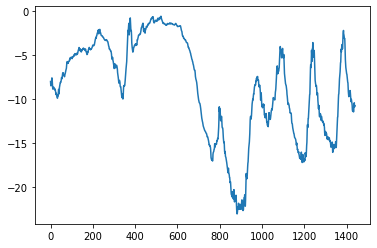

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 데이터가 이미 수치형이므로 추가적인 벡터화가 필요하지 않습니다. 하지만 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다(예를 들어 온도는 일반적으로 -20도에서 +30도 사이이고, 밀리바(mb)로 측정된 기압은 1,000 근처의 값입니다). 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다(샘플 `N`과 샘플 `N + 1`은 대부분 타임스텝이 비슷합니다). 모든 샘플을 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용해 그때 그때 배치를 만들겠습니다.

각 시계열 특성에 대해 평균을 빼고 표준 편차로 나누어 전처리합니다. 처음 200,000개 타임스텝을 훈련 데이터로 사용할 것이므로 전체 데이터에서 200,000개만 사용하여 평균과 표준 편차를 계산합니다:

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
print(float_data[:,1].mean())
print(float_data[:,1].std())

0.04211222174014063
0.9515228544484675


다음은 여기서 사용할 제너레이터입니다. 이 제너레이터 함수는 `(samples, targets)` 튜플을 반복적으로 반환합니다. `samples`는 입력 데이터로 사용할 배치이고 `targets`은 이에 대응되는 타깃 온도의 배열입니다.

 이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 14s 26ms/step - loss: 1.3771 - val_loss: 0.5165
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.4263 - val_loss: 0.3805
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2977 - val_loss: 0.3004
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2674 - val_loss: 0.3098
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2524 - val_loss: 0.3282
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2444 - val_loss: 0.3132
Epoch 7/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2363 - val_loss: 0.3064
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2314 - val_loss: 0.3331
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2284 - val_loss: 0.3259
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2245 - val_los

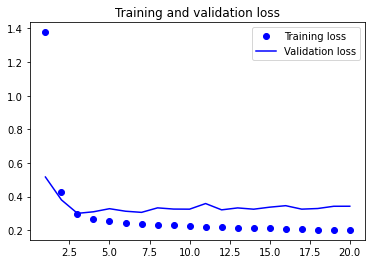

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

결과는 상식적인 수준의 기준점인 MAE 0.29 보다 좋지않다. 그 이유는 해당 모델이 핵심 정보를 찾지 못했기 때문이며 즉 시계열 데이터를 펼쳤기 때문에 시간 개념을 일어버렸다.

[과제] 상기 문제를 해결하기 위하여 순환 시퀀스 처리 모델을 적용하여 데이터 포인트의 시간 순서를 사용하여 과제를 수행하세요.(GRU,LSTM)

In [ ]:
# 순환 시퀀스 처리모델

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) # LSTM의 간단한 버전이 GRU를 사용
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 91s 178ms/step - loss: 0.3010 - val_loss: 0.2704
Epoch 2/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2832 - val_loss: 0.2656
Epoch 3/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2759 - val_loss: 0.2663
Epoch 4/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2732 - val_loss: 0.2634
Epoch 5/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2691 - val_loss: 0.2639
Epoch 6/20
500/500 [==============================] - 89s 179ms/step - loss: 0.2627 - val_loss: 0.2626
Epoch 7/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2595 - val_loss: 0.2682
Epoch 8/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2550 - val_loss: 0.2652
Epoch 9/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2515 - val_loss: 0.2675
Epoch 10/20
500/500 [==============================] - 89s 177ms/step - loss: 0.2478

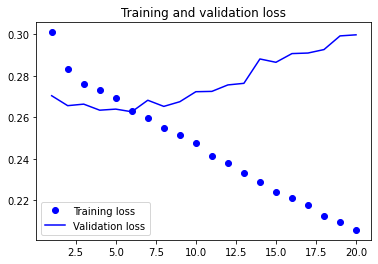

In [ ]:
# 상식적인 수준보다 상향됨

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] 과대적합을 줄이기 위한 방법을 수행하세요.
- 순환 드롭아웃
- 스태킹 순환층
- 양방향 RNN 사용

In [ ]:
# 순환 드롭아웃 사용

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2, # 순환 드롭아웃 적용
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 156s 307ms/step - loss: 0.3284 - val_loss: 0.2775
Epoch 2/40
500/500 [==============================] - 153s 305ms/step - loss: 0.3090 - val_loss: 0.2767
Epoch 3/40
500/500 [==============================] - 153s 305ms/step - loss: 0.3032 - val_loss: 0.2722
Epoch 4/40
500/500 [==============================] - 153s 307ms/step - loss: 0.2968 - val_loss: 0.2697
Epoch 5/40
500/500 [==============================] - 153s 306ms/step - loss: 0.2936 - val_loss: 0.2689
Epoch 6/40
500/500 [==============================] - 152s 304ms/step - loss: 0.2896 - val_loss: 0.2721
Epoch 7/40
500/500 [==============================] - 152s 303ms/step - loss: 0.2818 - val_loss: 0.2751
Epoch 8/40
500/500 [==============================] - 153s 307ms/step - loss: 0.2785 - val_loss: 0.2697
Epoch 9/40
500/500 [==============================] - 153s 305ms/step - loss: 0.2748 - val_loss: 0.2745
Epoch 10/40
500/500 [==============================] - 152s 303ms/step - lo

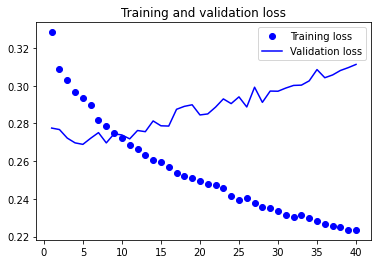

In [ ]:
# 과대적합이 더 늦게 시작된다

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 스태킹 RNN 수행

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',  # 네트워크의 용량을 늘리기 위하여 층을 추가하고 유닛수를 64로 늘림
                     dropout=0.1,  
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 424s 838ms/step - loss: 0.3248 - val_loss: 0.2781
Epoch 2/40
500/500 [==============================] - 413s 827ms/step - loss: 0.3030 - val_loss: 0.2749
Epoch 3/40
500/500 [==============================] - 411s 822ms/step - loss: 0.2962 - val_loss: 0.2679
Epoch 4/40
500/500 [==============================] - 412s 823ms/step - loss: 0.2866 - val_loss: 0.2639
Epoch 5/40
500/500 [==============================] - 411s 822ms/step - loss: 0.2809 - val_loss: 0.2715
Epoch 6/40
500/500 [==============================] - 426s 851ms/step - loss: 0.2758 - val_loss: 0.2678
Epoch 7/40
500/500 [==============================] - 420s 840ms/step - loss: 0.2707 - val_loss: 0.2772
Epoch 8/40
500/500 [==============================] - 406s 813ms/step - loss: 0.2641 - val_loss: 0.2855
Epoch 9/40
500/500 [==============================] - 404s 809ms/step - loss: 0.2600 - val_loss: 0.2763
Epoch 10/40
500/500 [==============================] - 405s 810ms/step - lo

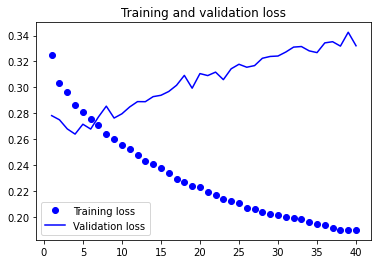

In [ ]:
# 성능이 살짝 상승하긴 했지만 늘어나는 비용에 비해 너무 적으므로 사용할때 생각할 필요가 있음

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 양방향 RNN 사용

# 시간순서를 뒤집어주는 함수
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
# 역방향으로 RNN 수행

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


500/500 [==============================] - 91s 178ms/step - loss: 0.4793 - val_loss: 0.4681
Epoch 2/20
500/500 [==============================] - 91s 183ms/step - loss: 0.4212 - val_loss: 0.4482
Epoch 3/20
500/500 [==============================] - 93s 186ms/step - loss: 0.3769 - val_loss: 0.4288
Epoch 4/20
500/500 [==============================] - 93s 187ms/step - loss: 0.3468 - val_loss: 0.3999
Epoch 5/20
500/500 [==============================] - 92s 183ms/step - loss: 0.3282 - val_loss: 0.3824
Epoch 6/20
500/500 [==============================] - 91s 182ms/step - loss: 0.3116 - val_loss: 0.3616
Epoch 7/20
500/500 [==============================] - 92s 185ms/step - loss: 0.2989 - val_loss: 0.3743
Epoch 8/20
500/500 [==============================] - 92s 184ms/step - loss: 0.2878 - val_loss: 0.3602
Epoch 9/20
500/500 [==============================] - 90s 179ms/step - loss: 0.2785 - val_loss: 0.3477
Epoch 10/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2723

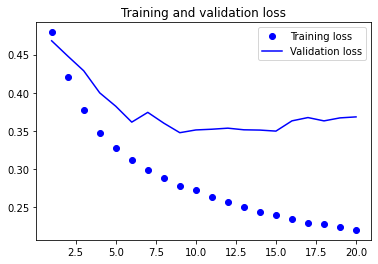

In [ ]:
# 성능은 오히려 많이 나빠졌다.

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 양방향 RNN 수행

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 176s 344ms/step - loss: 0.2947 - val_loss: 0.2711
Epoch 2/40
500/500 [==============================] - 180s 359ms/step - loss: 0.2771 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 170s 340ms/step - loss: 0.2692 - val_loss: 0.2632
Epoch 4/40
500/500 [==============================] - 165s 330ms/step - loss: 0.2639 - val_loss: 0.2714
Epoch 5/40
500/500 [==============================] - 166s 332ms/step - loss: 0.2571 - val_loss: 0.2730
Epoch 6/40
500/500 [==============================] - 175s 351ms/step - loss: 0.2527 - val_loss: 0.2738
Epoch 7/40
500/500 [==============================] - 165s 330ms/step - loss: 0.2444 - val_loss: 0.2831
Epoch 8/40
500/500 [==============================] - 159s 317ms/step - loss: 0.2402 - val_loss: 0.2777
Epoch 9/40
500/500 [==============================] - 164s 328ms/step - loss: 0.2344 - val_loss: 0.2761
Epoch 10/40
500/500 [==============================] - 162s 325ms/step - lo

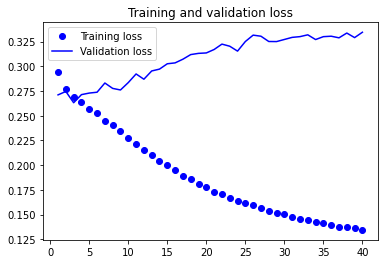

In [ ]:
# 온도데이터의 경우 시간시퀀스가 중요하므로 양방향 RNN을 수행시 오히려 성능이 안좋아짐
# 시간순서가 크게 중요하지 않은 텍스트 감성분석같은 경우에는 양방향 RNN이 효과가 좋을 가능성이 높다.

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 정리
- 상식수준의 기준점을 설정해서 성능을 가늠해는것이 좋다.
- 처음에는 간단한 모델부터 시도
- 시간순서가 중요하다면 순환층이 적합함.
- 순환네트워크에서 드롭아웃을 사용하려면 순환층에 dropout 과 recurrent_dropout 매개변수를 활용하면 된다.
- 스태킹 RNN은 단일 RNN보다 강력하지만 계산비용이 많이 들기에 작고 간단한 문제에서는 시도할 가치가 적다.
- 양방향 RNN은 자연어처리에 유용하지만 최근정보가 더 의미있는 시퀀스 데이터에서는 잘 작동하지 않음. 